# Import segmented lekemia cells from U-net and Linknet

In [1]:
# Drive
from google.colab import drive
from google.colab import files

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

Lekemia cells were split into Healthy, Lymphoblast and Myeloblast

Import Training data

In [17]:
SIZE = 256  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = []

In [18]:
for directory_path in glob.glob("/content/drive/MyDrive/Leukemia/CNN/Train/Unet/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

/content/drive/MyDrive/Leukemia/CNN/Train/Unet/Unet_healthy
/content/drive/MyDrive/Leukemia/CNN/Train/Unet/Unet_lymphoblast
/content/drive/MyDrive/Leukemia/CNN/Train/Unet/Unet_myeloblast


In [19]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Import Test data

In [20]:
test_images = []
test_labels = []

In [21]:
for directory_path in glob.glob("/content/drive/MyDrive/Leukemia/CNN/Test/Unet/**"):
    label = directory_path.split("\\")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

In [22]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Pre-processing data

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [24]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [25]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [26]:
#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Function to use transfer learning for feature extraction and machine learning for classification

In [27]:
from keras.applications import VGG16, InceptionV3, ResNet50
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# Define a function to train and evaluate the given model
def train_evaluate_model(model, model_name):
    # Load the selected pre-trained model
    pre_trained_model = model(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

    # Make loaded layers as non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Print model summary
    pre_trained_model.summary()

    # Extract features from the model
    feature_extractor = pre_trained_model.predict(x_train)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)

    # Create and train the Random Forest Classifier
    RF_model = RandomForestClassifier(n_estimators=50, random_state=42)
    RF_model.fit(features, y_train)

    # Extract features from the test set
    X_test_feature = pre_trained_model.predict(x_test)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

    # Make predictions using the trained RF model
    prediction_RF = RF_model.predict(X_test_features)

    # Inverse transform to get original labels
    prediction_RF = le.inverse_transform(prediction_RF)

    prediction_encoded = le.transform(prediction_RF)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels_encoded, prediction_encoded)
    print(f"{model_name} Accuracy: {accuracy:.2f}")

    # Calculate confusion matrix
    cm = confusion_matrix(test_labels_encoded, prediction_encoded)
    print(f"{model_name} Confusion Matrix:\n{cm}")
    sns.heatmap(cm, annot=True)

    # Calculate classification report
    class_names = le.classes_
    classification_rep = classification_report(test_labels_encoded, prediction_encoded, target_names=class_names)
    print(f"{model_name} Classification Report:\n{classification_rep}")

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

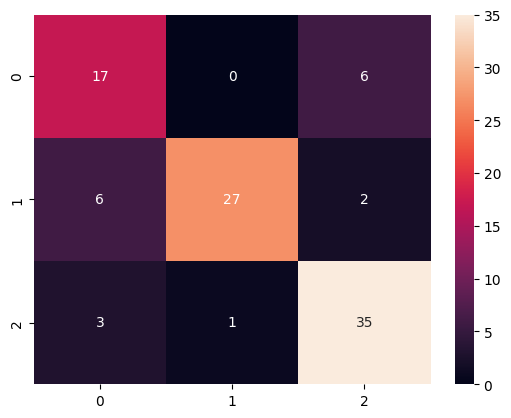

In [30]:
train_evaluate_model(VGG16, "VGG16")

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalizati

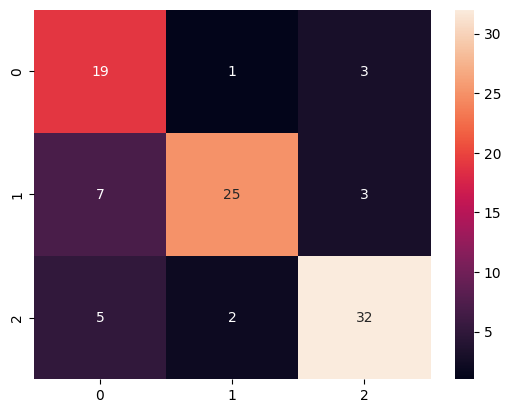

In [28]:
train_evaluate_model(InceptionV3, "InceptionV3")

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

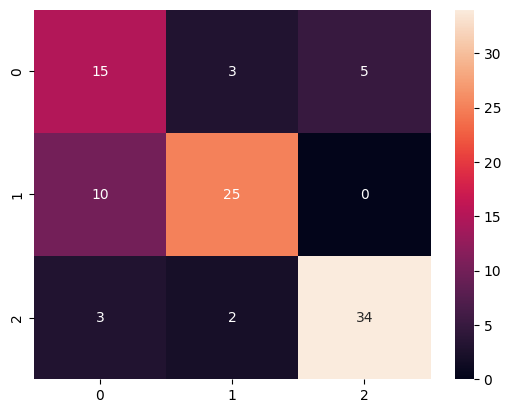

In [29]:
train_evaluate_model(ResNet50, "ResNet50")